## Landslide4Sense Example

In [ ]:
!pip install terratorch==0.99.8

In [1]:
import os
import sys
import numpy as np
import torch

import terratorch
from terratorch.datamodules import Landslide4SenseNonGeoDataModule
from terratorch.datasets import Landslide4SenseNonGeo
from terratorch.tasks import SemanticSegmentationTask

import albumentations

import lightning.pytorch as pl
from lightning.pytorch.loggers import TensorBoardLogger
from lightning.pytorch.callbacks import ModelCheckpoint

INFO:albumentations.check_version:A new version of Albumentations is available: 2.0.4 (you have 1.4.10). Upgrade using: pip install --upgrade albumentations


If you have the data already downloaded, update the `DATASET_PATH`. Otherwise, download it with the following code. 
Check [here](https://huggingface.co/datasets/ibm-nasa-geospatial/Landslide4sense) for more details on this dataset.

In [2]:
DATASET_PATH = "./data"

In [ ]:
from huggingface_hub import snapshot_download

repo_id = "ibm-nasa-geospatial/Landslide4sense"
_ = snapshot_download(repo_id=repo_id, repo_type="dataset", cache_dir="./cache", local_dir=DATASET_PATH)

In [3]:
OUT_DIR = "./landslide_example"  # where to save checkpoints and log files

BATCH_SIZE = 16
EPOCHS = 40
LR = 1.0e-4
WEIGHT_DECAY = 0.1
HEAD_DROPOUT=0.1
FREEZE_BACKBONE = False

BANDS = ["BLUE", "GREEN", "RED", "NIR_BROAD", "SWIR_1", "SWIR_2"]
NUM_WORKERS = 7   # adjust value based on your system

SEED = 0

#### Exploring the dataset

In [4]:
data_module = Landslide4SenseNonGeoDataModule(
    data_root=DATASET_PATH,
)

In [5]:
# Checking the dataset means and stds
print(data_module.means)
print(data_module.stds)

[-0.4914, -0.3074, -0.1277, -0.0625, 0.0439, 0.0803, 0.0644, 0.0802, 0.3, 0.4082, 0.0823, 0.0516, 0.3338, 0.7819]
[0.9325, 0.8775, 0.886, 0.8869, 0.8857, 0.8418, 0.8354, 0.8491, 0.9061, 1.6072, 0.8848, 0.9232, 0.9018, 1.2913]


In [6]:
# Checking train split size
data_module.setup("fit")
train_dataset = data_module.train_dataset
len(train_dataset)

3799

In [7]:
# Checking available bands
train_dataset.all_band_names

('COASTAL AEROSOL',
 'BLUE',
 'GREEN',
 'RED',
 'RED_EDGE_1',
 'RED_EDGE_2',
 'RED_EDGE_3',
 'NIR_BROAD',
 'WATER_VAPOR',
 'CIRRUS',
 'SWIR_1',
 'SWIR_2',
 'SLOPE',
 'DEM')

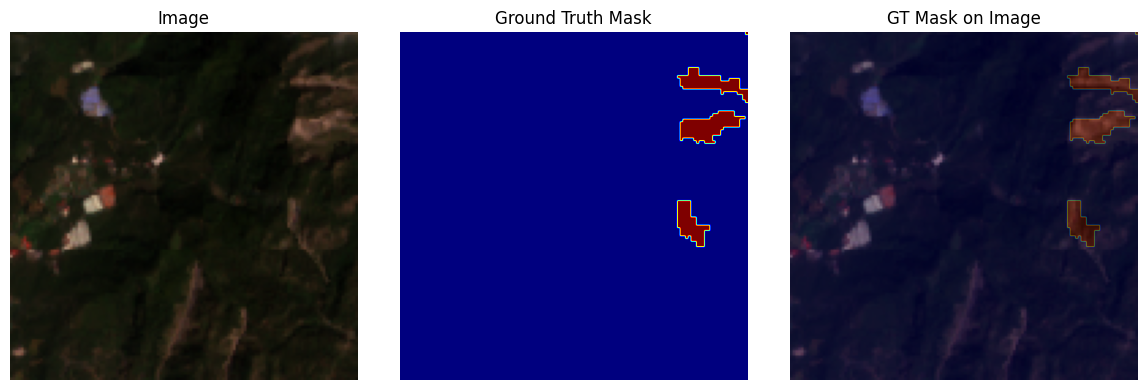

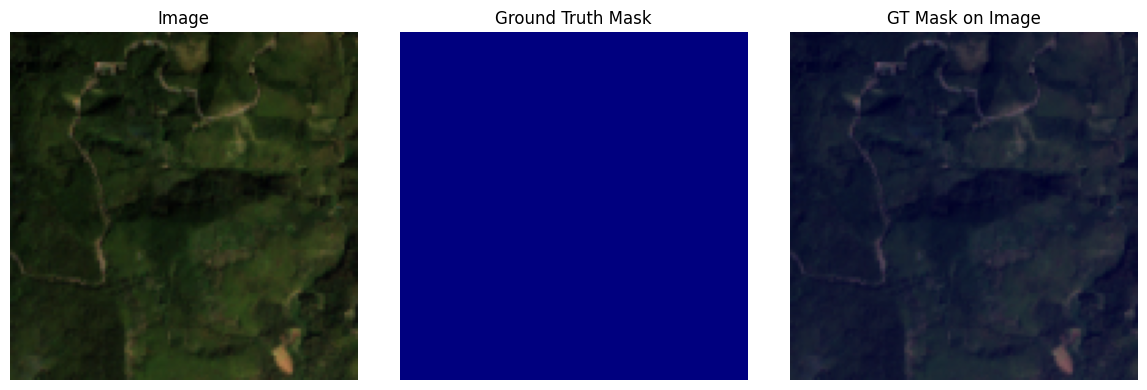

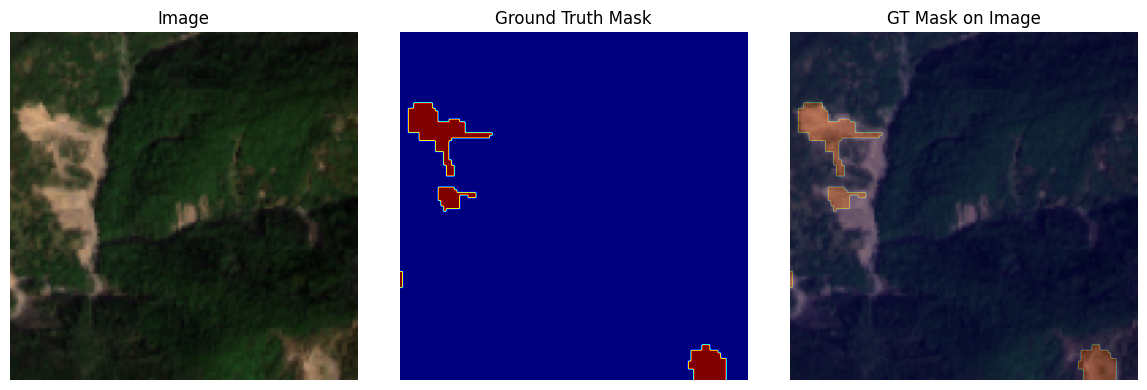

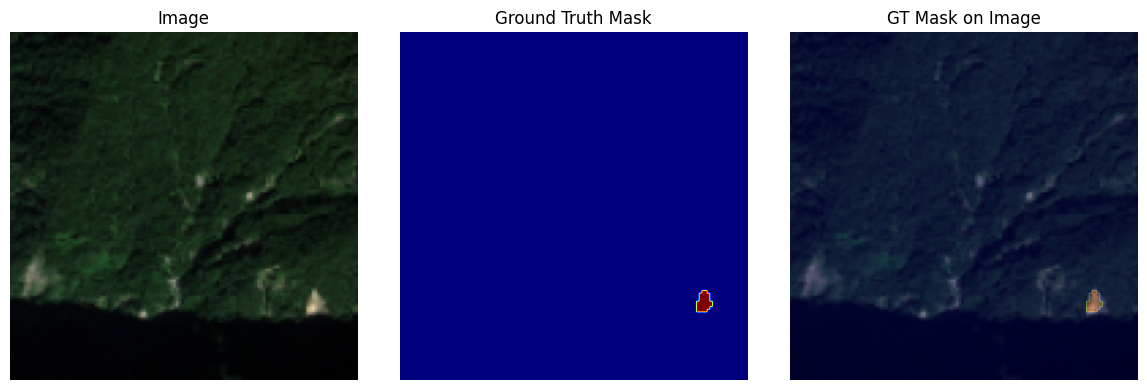

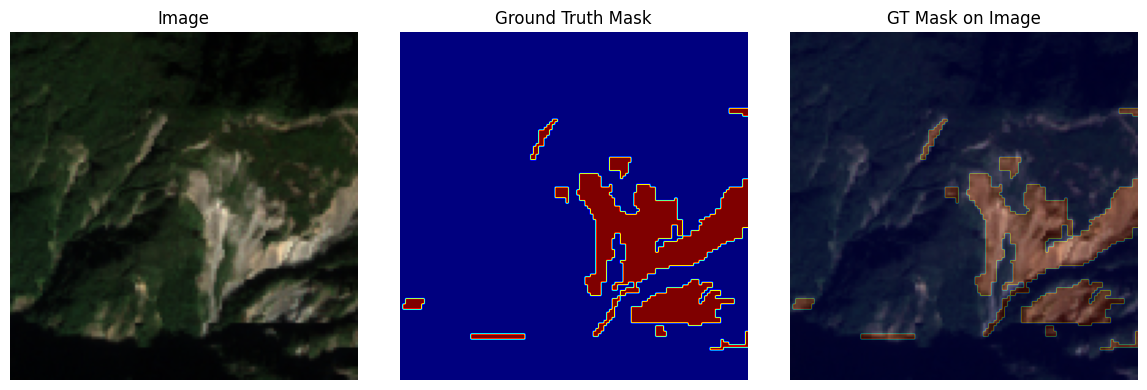

In [8]:
# Ploting a few samples
for i in range(5):
    train_dataset.plot(train_dataset[i])

In [9]:
# Checking validation split size
val_dataset = data_module.val_dataset
len(val_dataset)

245

In [10]:
# Checking test split
data_module.setup("test")
test_dataset = data_module.test_dataset
len(test_dataset)

800

#### Training setup

In [11]:
pl.seed_everything(SEED)

# Logger
logger = TensorBoardLogger(
    save_dir=OUT_DIR,
    name="landslide_example",
)

# Callbacks
checkpoint_callback = ModelCheckpoint(
    monitor="val/Multiclass_Jaccard_Index",
    mode="max",
    dirpath=os.path.join(OUT_DIR, "landslide_example", "checkpoints"),
    filename="best-checkpoint-{epoch:02d}-{val_loss:.2f}",
    save_top_k=1,
)

# Trainer
trainer = pl.Trainer(
    accelerator="auto",
    strategy="auto",
    devices="auto",
    precision="bf16-mixed",
    num_nodes=1,
    logger=logger,
    max_epochs=EPOCHS,
    check_val_every_n_epoch=1,
    log_every_n_steps=10,
    enable_checkpointing=True,
    callbacks=[checkpoint_callback],
)

INFO: Seed set to 0
INFO:lightning.fabric.utilities.seed:Seed set to 0
INFO: Using bfloat16 Automatic Mixed Precision (AMP)
INFO:lightning.pytorch.utilities.rank_zero:Using bfloat16 Automatic Mixed Precision (AMP)
INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs


In [12]:
# DataModule

transforms = [
    albumentations.Resize(224, 224),
    albumentations.pytorch.transforms.ToTensorV2(),
]

# Adding augmentations for training
train_transforms = [
    albumentations.HorizontalFlip(),
    albumentations.Resize(224, 224),
    albumentations.pytorch.transforms.ToTensorV2(),
]

data_module = Landslide4SenseNonGeoDataModule(
    batch_size=BATCH_SIZE,
    bands=BANDS,
    data_root=DATASET_PATH,
    train_transform=train_transforms,
    val_transforms=transforms,
    test_transforms=transforms,
    num_workers=NUM_WORKERS,
)

In [ ]:
# Model

backbone_args = dict(
    backbone_pretrained=True,
    backbone="prithvi_eo_v2_300", # prithvi_eo_v2_300, prithvi_eo_v2_300_tl, prithvi_eo_v2_600, prithvi_eo_v2_600_tl
    backbone_bands=BANDS,
    backbone_num_frames=1,
)

decoder_args = dict(
    decoder="UperNetDecoder",
    decoder_channels=256,
    decoder_scale_modules=True,
)

necks = [
    dict(
            name="SelectIndices",
            # indices=[2, 5, 8, 11]    # indices for prithvi_eo_v1_100
            indices=[5, 11, 17, 23],   # indices for prithvi_eo_v2_300
            # indices=[7, 15, 23, 31]  # indices for prithvi_eo_v2_600
        ),
    dict(
            name="ReshapeTokensToImage",
        )
    ]

model_args = dict(
    **backbone_args,
    **decoder_args,
    num_classes=2,
    head_dropout=HEAD_DROPOUT,
    head_channel_list=[128, 64],
    necks=necks,
    rescale=True,
)
    

model = SemanticSegmentationTask(
    model_args=model_args,
    plot_on_val=False,
    loss="focal",
    lr=LR,
    optimizer="AdamW",
    scheduler="StepLR",
    scheduler_hparams={"step_size": 10, "gamma": 0.9},
    optimizer_hparams=dict(weight_decay=WEIGHT_DECAY),
    ignore_index=-1,
    freeze_backbone=FREEZE_BACKBONE,
    freeze_decoder=False,
    model_factory="EncoderDecoderFactory",
)

#### Training and testing the model

In [ ]:
# Training
trainer.fit(model, datamodule=data_module)

In [ ]:
ckpt_path = checkpoint_callback.best_model_path

# Test results
test_results = trainer.test(model, datamodule=data_module, ckpt_path=ckpt_path)

In [16]:
test_results

[{'test/loss': 3.0330820663948543e-06,
  'test/Multiclass_Accuracy': 0.9844433665275574,
  'test/multiclassaccuracy_0': 0.9961121678352356,
  'test/multiclassaccuracy_1': 0.3782273828983307,
  'test/Multiclass_F1_Score': 0.9844433665275574,
  'test/Multiclass_Jaccard_Index': 0.6495010256767273,
  'test/multiclassjaccardindex_0': 0.9843314290046692,
  'test/multiclassjaccardindex_1': 0.314670592546463,
  'test/Multiclass_Jaccard_Index_Micro': 0.9693633317947388}]